In [1]:
grid_file = '/home/benr/src/ssm-analysis/SSM_Grid/ssm_grid.2dm'

import configparser
import re
import os

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fvcom import FvcomGrid, Transect, ControlVolume

In [26]:
data = Dataset('results/doxg.nc')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(4380), node(3137), nele(4129), siglay(10), siglev(11)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 siglay(siglay), float32 siglev(siglev), float32 zeta(time, node), float32 controlDOXG(time, siglay, node), float32 c2936DOXG(time, siglay, node), float32 q1c454DOXG(time, siglay, node), float32 q1c10DOXG(time, siglay, node), float32 q1c15DOXG(time, siglay, node), float32 q1c20DOXG(time, siglay, node), float32 q1c25DOXG(time, siglay, node), float32 q1c2936DOXG(time, siglay, node), float32 q3c454DOXG(time, siglay, node), float32 q3c10DOXG(time, siglay, node), float32 q3c15DOXG(time, siglay, node), float32 q3c20DOXG(time, siglay, node), float32 q3c25DOXG(time, siglay, node), float32 q3c2936DOXG(time, siglay, node), float32 q5c454DOXG(time, siglay, 

In [3]:
def sort(vs):
    r = re.compile('q([1-9])c([0-9]+)')
    dec = []
    for v in vs:
        if v[-4:] != 'DOXG':
            continue
        n = v[:-4] # Remove 'DOXG'
        m = r.match(n)
        if m:
            q = m.group(1)
            c = m.group(2)
            if c == '454':
                c = '0' + c
        else:
            if n == 'control':
                q = '0'
                c = '0'
            else:
                q = '0'
                c = '1'
        dec.append((q, c, v))
    dec.sort()
    return [v for q, c, v in dec]

sort(data.variables)

['controlDOXG',
 'c2936DOXG',
 'q1c454DOXG',
 'q1c10DOXG',
 'q1c15DOXG',
 'q1c20DOXG',
 'q1c25DOXG',
 'q1c2936DOXG',
 'q3c454DOXG',
 'q3c10DOXG',
 'q3c15DOXG',
 'q3c20DOXG',
 'q3c25DOXG',
 'q3c2936DOXG',
 'q5c454DOXG',
 'q5c10DOXG',
 'q5c15DOXG',
 'q5c20DOXG',
 'q5c25DOXG',
 'q5c2936DOXG',
 'q7c454DOXG',
 'q7c10DOXG',
 'q7c15DOXG',
 'q7c20DOXG',
 'q7c25DOXG',
 'q7c2936DOXG',
 'q9c454DOXG',
 'q9c10DOXG',
 'q9c15DOXG',
 'q9c20DOXG',
 'q9c25DOXG',
 'q9c2936DOXG']

In [4]:
grid = FvcomGrid.from_mesh(grid_file)
areas = grid.tces_gdf().loc[data['node'][:]].area
areas

4478     1.290208e+06
4479     1.012244e+06
4480     1.511056e+06
4481     1.856297e+06
4482     1.190541e+06
             ...     
15989    2.452663e+05
15993    2.198963e+05
15994    1.809223e+05
16000    9.728483e+04
16003    2.510567e+05
Length: 3137, dtype: float64

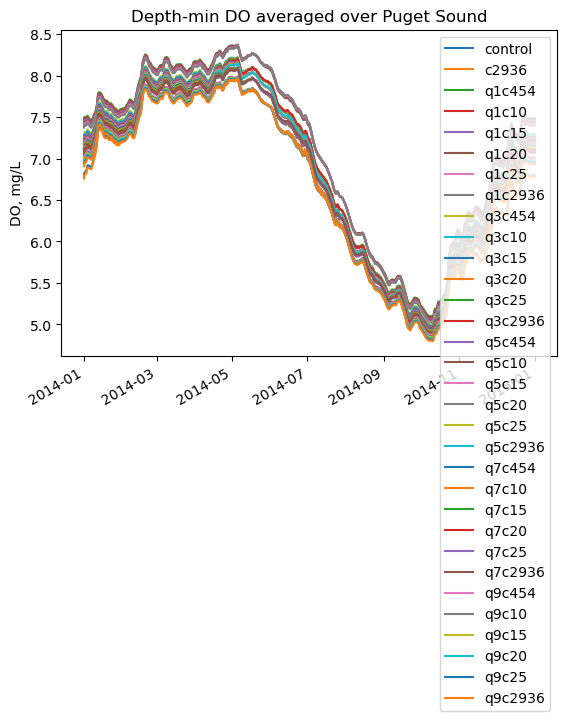

In [5]:
dates = pd.Timestamp(data.model_start) + pd.to_timedelta(data['time'][:], 'D')
fig, ax = plt.subplots()
mindo_avgs = {}
for v in sort(data.variables):
    name = v[:-4]
    ser = pd.Series(np.average(data[v][:].min(axis=1), axis=1, weights=areas), index=dates)
    ser.rolling('1D').mean().plot(ax=ax, label=name)
    mindo_avgs[name] = ser
mindo_avgs_df = pd.DataFrame(mindo_avgs)
ax.set(title='Depth-min DO averaged over Puget Sound', ylabel='DO, mg/L')
ax.legend()

In [6]:
mindo_avgs_df.mean()

control    6.703268
c2936      6.691694
q1c454     7.101779
q1c10      7.092084
q1c15      7.083132
q1c20      7.074193
q1c25      7.065211
q1c2936    7.057402
q3c454     6.954265
q3c10      6.944184
q3c15      6.934862
q3c20      6.925502
q3c25      6.916109
q3c2936    6.907911
q5c454     6.903720
q5c10      6.893546
q5c15      6.884082
q5c20      6.874615
q5c25      6.865077
q5c2936    6.856753
q7c454     6.841989
q7c10      6.831689
q7c15      6.822084
q7c20      6.812449
q7c25      6.802761
q7c2936    6.807902
q9c454     6.739337
q9c10      6.728949
q9c15      6.719256
q9c20      6.709475
q9c25      6.699632
q9c2936    6.691051
dtype: float64

In [7]:
mindo_avgs_df.to_excel('results/puget_sound/do_min_avg.xlsx')

In [8]:
sections_file = 'inlet_sections_aurora.ini'
sections_config = configparser.ConfigParser()
sections_config.read(sections_file)

# names of sections that bound each control volume
cv_bounds = {
    'Penn Cove': ['PennCove'],
    'Holmes Harbor': ['HolmesHbr'],
    'Crescent Bay': ['CrescentBy'],
    'Carr Inlet': ['CarrInl'],
    'Case Inlet': ['CaseInl'],
    'Elliot Bay': ['ElliotBy'],
    'Commencement Bay': ['CommenceBy'],
    'Dabob Bay': ['DabobBy'],
    'Port Susan': ['PtSusan','StillaguamishSouthFork','StillaguamishPassSouth'],
    'Dyes Inlet': ['DyesInl'],
    'Sinclair Inlet': ['SinclairInl'],
    'Quartermaster Harbor': ['QtrHbr'],
    'Lynch Cove': ['LynchCove']
}

In [9]:
dirname = lambda n: n.lower().replace(' ', '_')

cvs = {}
for name, sectnames in cv_bounds.items():
    transects = []
    display(name)
    for sn in sectnames:
        waypoints = np.array(sections_config[sn]['waypoints'].split(' ')).astype(int)
        t = Transect.shortest(grid, waypoints)
        transects.append(t)
    cvs[name] = ControlVolume.from_transects(transects, calc=True)
    if not os.path.isdir(f'results/{dirname(name)}'):
        os.mkdir(f'results/{dirname(name)}')
    display(len(cvs[name].nodes))

'Penn Cove'

14

'Holmes Harbor'

26

'Crescent Bay'

10

'Carr Inlet'

157

'Case Inlet'

100

'Elliot Bay'

166

'Commencement Bay'

60

'Dabob Bay'

104

'Port Susan'

190

'Dyes Inlet'

42

'Sinclair Inlet'

16

'Quartermaster Harbor'

40

'Lynch Cove'

96

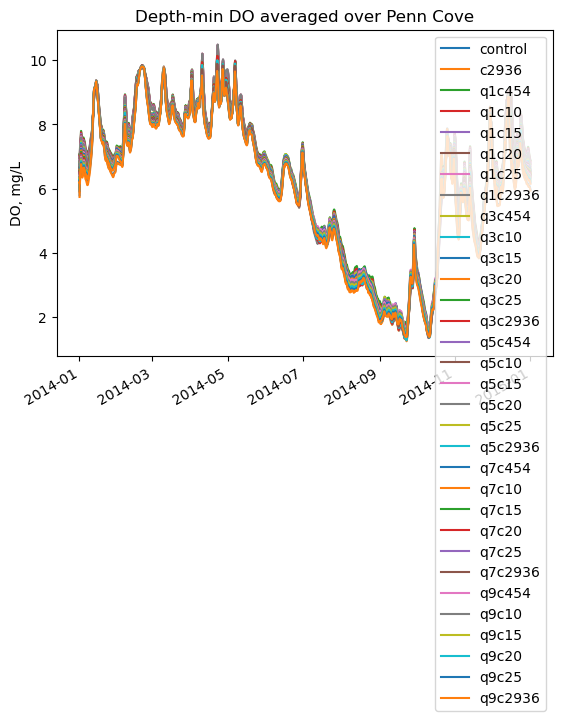

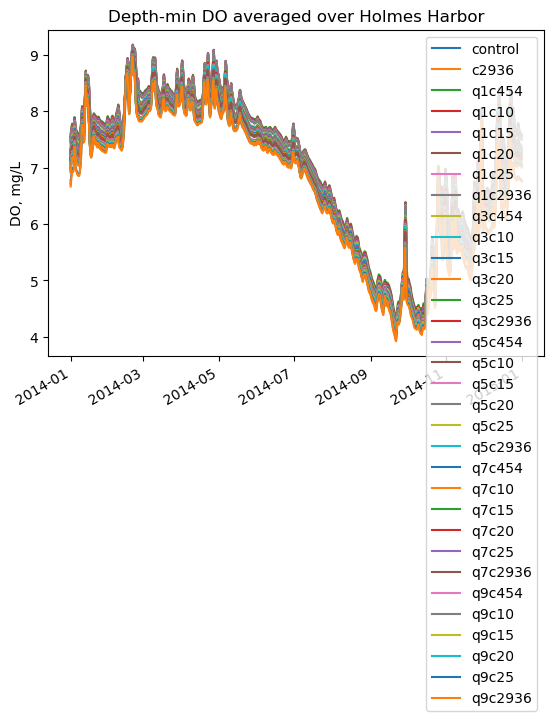

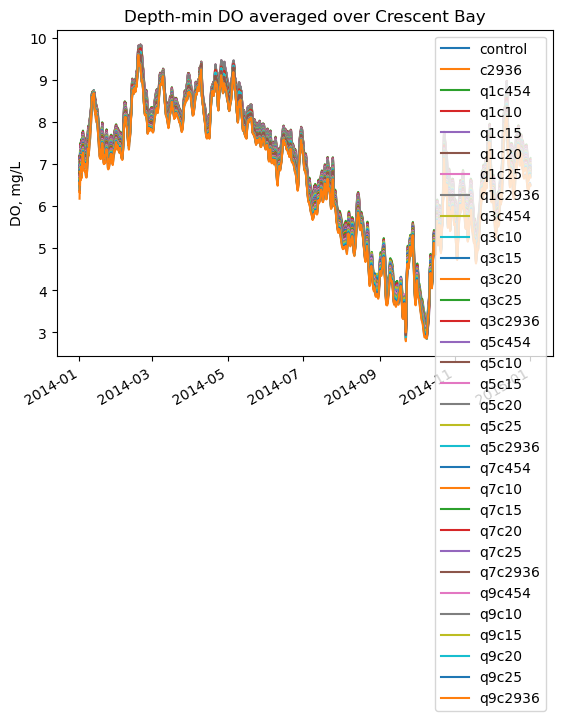

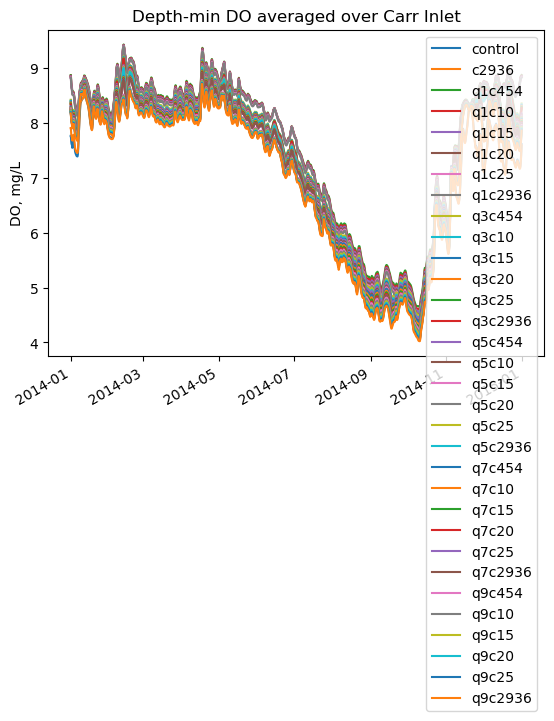

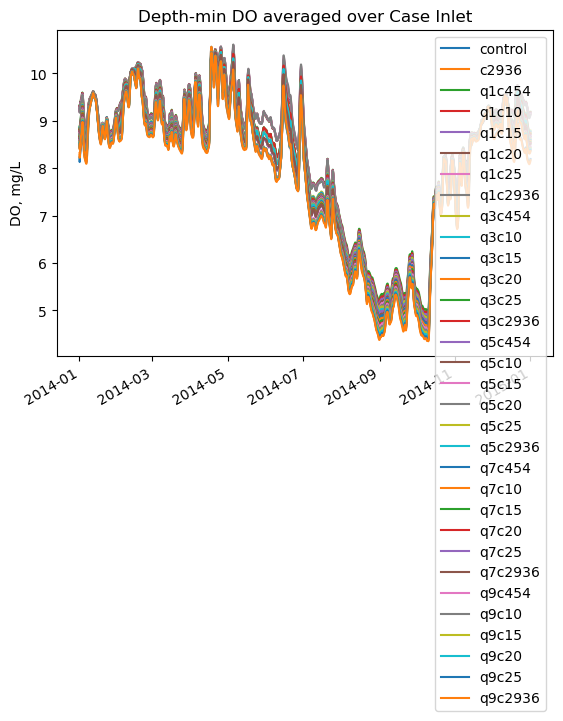

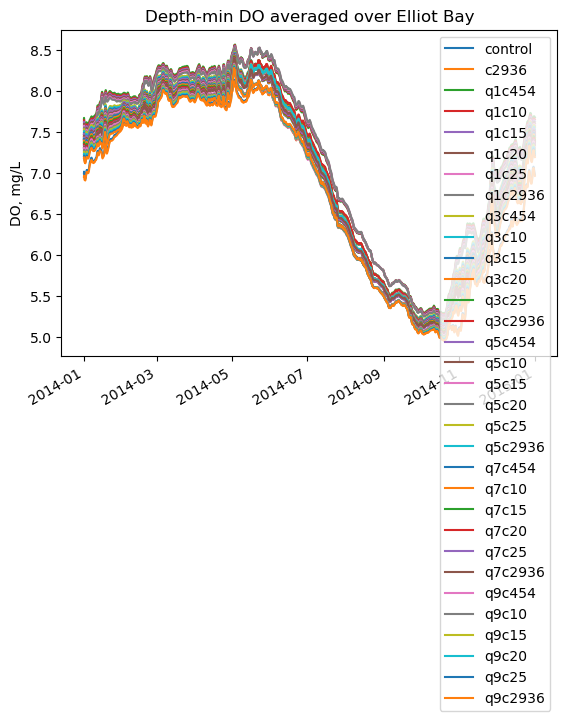

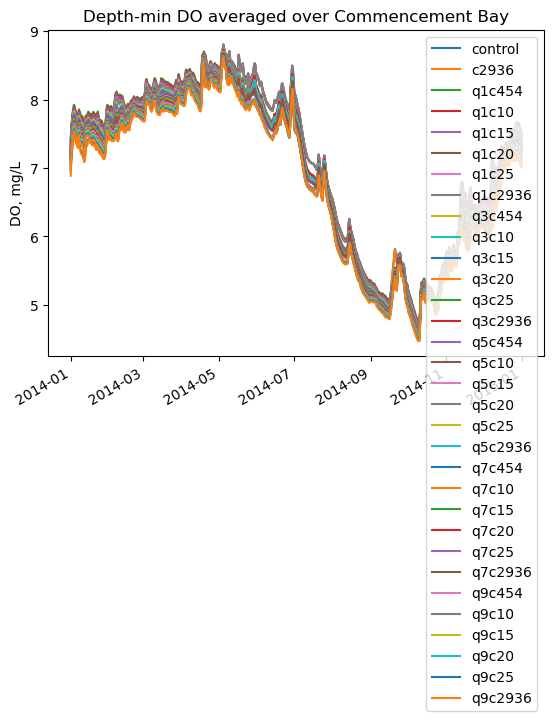

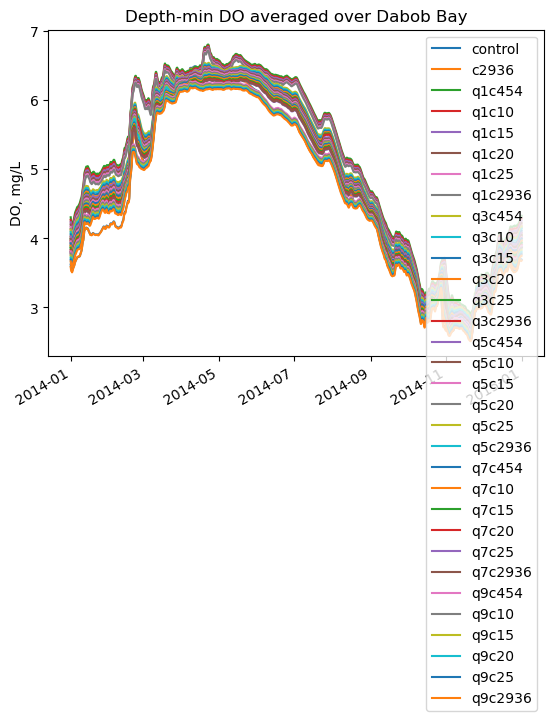

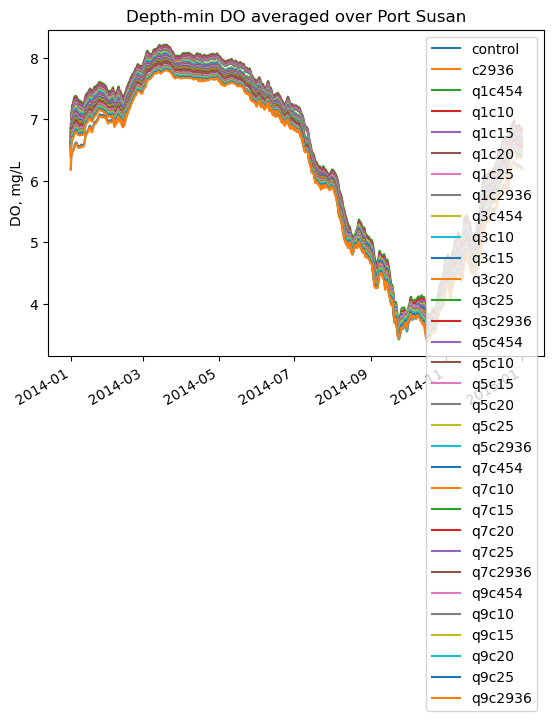

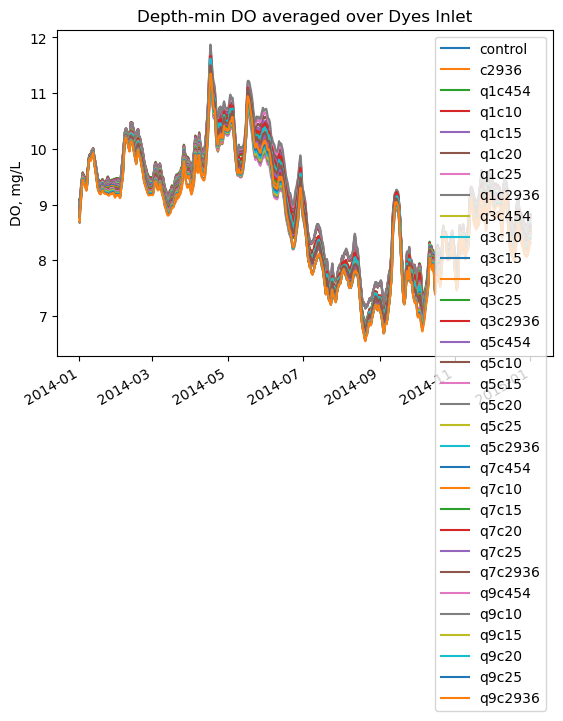

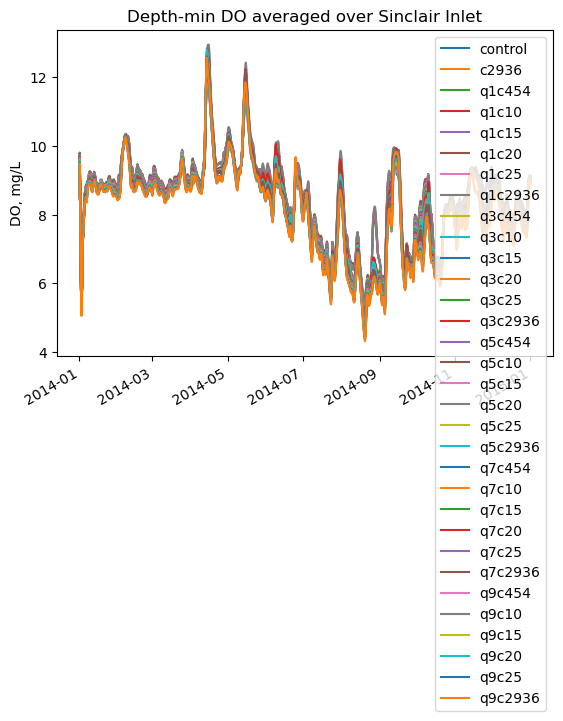

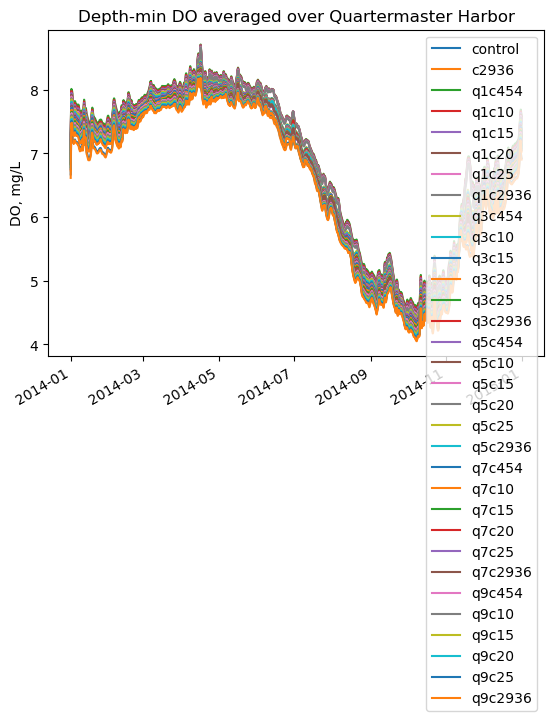

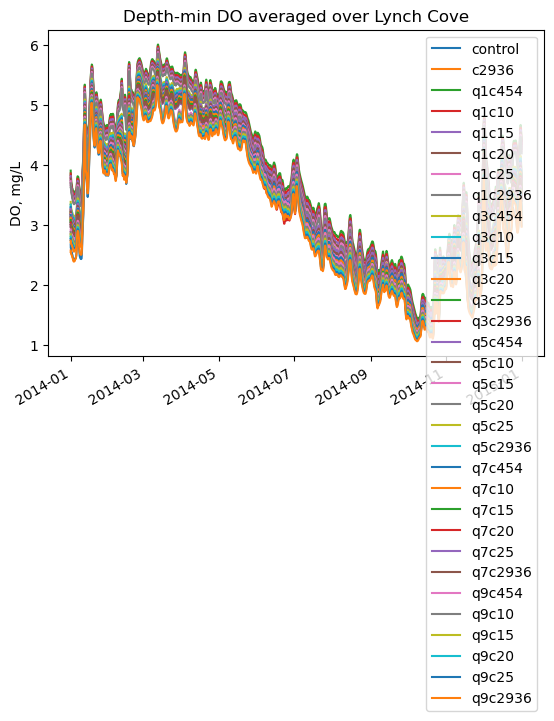

In [10]:
mindo_avgs_by_cv = {}
for cvname,cv in cvs.items():
    fig, ax = plt.subplots()
    mindo_avgs = {}
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for v in sort(data.variables):
        name = v[:-4]
        ser = pd.Series(np.average(data[v][:,:,idxs].min(axis=1), axis=1, weights=areas.iloc[idxs]), index=dates)
        ser.rolling('1D').mean().plot(ax=ax, label=name)
        mindo_avgs[name] = ser
    mindo_avgs_by_cv[cvname] = pd.DataFrame(mindo_avgs)
    ax.set(title=f'Depth-min DO averaged over {cvname}', ylabel='DO, mg/L')
    ax.legend()

In [11]:
for name,df in mindo_avgs_by_cv.items():
    display(name)
    display(df.mean())
    df.to_excel(f'results/{dirname(name)}/do_min_avg.xlsx')

'Penn Cove'

control    6.004067
c2936      5.972943
q1c454     6.435363
q1c10      6.392788
q1c15      6.353404
q1c20      6.314217
q1c25      6.275228
q1c2936    6.241633
q3c454     6.325048
q3c10      6.284558
q3c15      6.246858
q3c20      6.209043
q3c25      6.171374
q3c2936    6.138804
q5c454     6.289065
q5c10      6.249279
q5c15      6.212089
q5c20      6.174925
q5c25      6.137712
q5c2936    6.105523
q7c454     6.238880
q7c10      6.199887
q7c15      6.163392
q7c20      6.126753
q7c25      6.090218
q7c2936    6.079620
q9c454     6.159325
q9c10      6.121881
q9c15      6.086842
q9c20      6.051481
q9c25      6.016069
q9c2936    5.985382
dtype: float64

'Holmes Harbor'

control    6.677620
c2936      6.658947
q1c454     7.150786
q1c10      7.130202
q1c15      7.111025
q1c20      7.091925
q1c25      7.072705
q1c2936    7.055940
q3c454     7.006617
q3c10      6.986303
q3c15      6.967448
q3c20      6.948498
q3c25      6.929414
q3c2936    6.912778
q5c454     6.955420
q5c10      6.935420
q5c15      6.916731
q5c20      6.897917
q5c25      6.878860
q5c2936    6.862261
q7c454     6.890892
q7c10      6.870891
q7c15      6.852176
q7c20      6.833343
q7c25      6.814393
q7c2936    6.812527
q9c454     6.780102
q9c10      6.760590
q9c15      6.742284
q9c20      6.723797
q9c25      6.705196
q9c2936    6.688978
dtype: float64

'Crescent Bay'

control    6.665758
c2936      6.645314
q1c454     7.102984
q1c10      7.077628
q1c15      7.054083
q1c20      7.030466
q1c25      7.006793
q1c2936    6.986212
q3c454     6.969922
q3c10      6.945333
q3c15      6.922415
q3c20      6.899292
q3c25      6.876057
q3c2936    6.855802
q5c454     6.919825
q5c10      6.895461
q5c15      6.872619
q5c20      6.849685
q5c25      6.826563
q5c2936    6.806400
q7c454     6.862407
q7c10      6.838362
q7c15      6.815829
q7c20      6.793137
q7c25      6.770324
q7c2936    6.766853
q9c454     6.764247
q9c10      6.740916
q9c15      6.719040
q9c20      6.696876
q9c25      6.674579
q9c2936    6.655134
dtype: float64

'Carr Inlet'

control    7.035410
c2936      7.012703
q1c454     7.640401
q1c10      7.620155
q1c15      7.601457
q1c20      7.582762
q1c25      7.564047
q1c2936    7.547816
q3c454     7.455959
q3c10      7.434112
q3c15      7.413877
q3c20      7.393583
q3c25      7.373294
q3c2936    7.355675
q5c454     7.389096
q5c10      7.366790
q5c15      7.346015
q5c20      7.325213
q5c25      7.304377
q5c2936    7.286281
q7c454     7.308197
q7c10      7.285197
q7c15      7.263749
q7c20      7.242245
q7c25      7.220779
q7c2936    7.219734
q9c454     7.167426
q9c10      7.143395
q9c15      7.121015
q9c20      7.098397
q9c25      7.075748
q9c2936    7.056080
dtype: float64

'Case Inlet'

control    7.889094
c2936      7.866675
q1c454     8.372351
q1c10      8.358578
q1c15      8.345838
q1c20      8.333065
q1c25      8.320299
q1c2936    8.309257
q3c454     8.210608
q3c10      8.194848
q3c15      8.180236
q3c20      8.165569
q3c25      8.150946
q3c2936    8.138277
q5c454     8.152095
q5c10      8.135673
q5c15      8.120391
q5c20      8.105103
q5c25      8.089781
q5c2936    8.076491
q7c454     8.075782
q7c10      8.058518
q7c15      8.042430
q7c20      8.026283
q7c25      8.010136
q7c2936    8.014198
q9c454     7.947999
q9c10      7.929608
q9c15      7.912472
q9c20      7.895176
q9c25      7.877859
q9c2936    7.862810
dtype: float64

'Elliot Bay'

control    6.787800
c2936      6.774737
q1c454     7.230716
q1c10      7.222424
q1c15      7.214756
q1c20      7.206995
q1c25      7.199158
q1c2936    7.192289
q3c454     7.084391
q3c10      7.075469
q3c15      7.067243
q3c20      7.058918
q3c25      7.050530
q3c2936    7.043167
q5c454     7.032311
q5c10      7.023232
q5c15      7.014815
q5c20      7.006325
q5c25      6.997736
q5c2936    6.990206
q7c454     6.973079
q7c10      6.963770
q7c15      6.955135
q7c20      6.946412
q7c25      6.937594
q7c2936    6.941898
q9c454     6.870723
q9c10      6.861095
q9c15      6.852158
q9c20      6.843085
q9c25      6.833913
q9c2936    6.825855
dtype: float64

'Commencement Bay'

control    6.890548
c2936      6.869118
q1c454     7.164855
q1c10      7.149969
q1c15      7.136271
q1c20      7.122511
q1c25      7.108674
q1c2936    7.096616
q3c454     7.046582
q3c10      7.031376
q3c15      7.017374
q3c20      7.003256
q3c25      6.989079
q3c2936    6.976679
q5c454     7.005205
q5c10      6.989885
q5c15      6.975731
q5c20      6.961481
q5c25      6.947102
q5c2936    6.934524
q7c454     6.957039
q7c10      6.941531
q7c15      6.927175
q7c20      6.912681
q7c25      6.898103
q7c2936    6.899269
q9c454     6.873719
q9c10      6.858055
q9c15      6.843497
q9c20      6.828781
q9c25      6.813950
q9c2936    6.800990
dtype: float64

'Dabob Bay'

control    4.670966
c2936      4.658164
q1c454     5.163166
q1c10      5.135968
q1c15      5.110846
q1c20      5.086190
q1c25      5.061558
q1c2936    5.040213
q3c454     4.992121
q3c10      4.966213
q3c15      4.942295
q3c20      4.918578
q3c25      4.894838
q3c2936    4.874229
q5c454     4.910670
q5c10      4.885293
q5c15      4.861589
q5c20      4.838217
q5c25      4.814797
q5c2936    4.794425
q7c454     4.826176
q7c10      4.801214
q7c15      4.777797
q7c20      4.754591
q7c25      4.731344
q7c2936    4.735814
q9c454     4.717001
q9c10      4.693017
q9c15      4.670599
q9c20      4.648128
q9c25      4.625603
q9c2936    4.606070
dtype: float64

'Port Susan'

control    6.137655
c2936      6.116620
q1c454     6.546543
q1c10      6.518936
q1c15      6.493447
q1c20      6.467992
q1c25      6.442463
q1c2936    6.420339
q3c454     6.425838
q3c10      6.399652
q3c15      6.375373
q3c20      6.351021
q3c25      6.326600
q3c2936    6.305339
q5c454     6.385597
q5c10      6.359990
q5c15      6.336088
q5c20      6.312164
q5c25      6.288134
q5c2936    6.267194
q7c454     6.333382
q7c10      6.308393
q7c15      6.285047
q7c20      6.261611
q7c25      6.238125
q7c2936    6.235850
q9c454     6.244500
q9c10      6.220760
q9c15      6.198559
q9c20      6.176139
q9c25      6.153609
q9c2936    6.133972
dtype: float64

'Dyes Inlet'

control    8.785561
c2936      8.778762
q1c454     9.108728
q1c10      9.114290
q1c15      9.119489
q1c20      9.124763
q1c25      9.129977
q1c2936    9.134428
q3c454     8.974192
q3c10      8.976792
q3c15      8.979328
q3c20      8.981862
q3c25      8.984372
q3c2936    8.986541
q5c454     8.922476
q5c10      8.924012
q5c15      8.925584
q5c20      8.927181
q5c25      8.928848
q5c2936    8.930240
q7c454     8.864275
q7c10      8.864755
q7c15      8.865231
q7c20      8.865762
q7c25      8.866193
q7c2936    8.877794
q9c454     8.763796
q9c10      8.762202
q9c15      8.760747
q9c20      8.759309
q9c25      8.757847
q9c2936    8.756586
dtype: float64

'Sinclair Inlet'

control    8.152828
c2936      8.139171
q1c454     8.592802
q1c10      8.589104
q1c15      8.585443
q1c20      8.581813
q1c25      8.577817
q1c2936    8.574028
q3c454     8.422150
q3c10      8.414069
q3c15      8.406668
q3c20      8.399104
q3c25      8.391361
q3c2936    8.384656
q5c454     8.358287
q5c10      8.348545
q5c15      8.339733
q5c20      8.330720
q5c25      8.321724
q5c2936    8.313865
q7c454     8.288827
q7c10      8.277673
q7c15      8.267483
q7c20      8.257445
q7c25      8.247237
q7c2936    8.254611
q9c454     8.173313
q9c10      8.159868
q9c15      8.147733
q9c20      8.135607
q9c25      8.123330
q9c2936    8.112717
dtype: float64

'Quartermaster Harbor'

control    6.506392
c2936      6.482982
q1c454     6.929134
q1c10      6.906833
q1c15      6.886228
q1c20      6.865556
q1c25      6.844793
q1c2936    6.826747
q3c454     6.781798
q3c10      6.759071
q3c15      6.738022
q3c20      6.716836
q3c25      6.695595
q3c2936    6.677070
q5c454     6.732563
q5c10      6.709778
q5c15      6.688616
q5c20      6.667341
q5c25      6.645940
q5c2936    6.627290
q7c454     6.682326
q7c10      6.659462
q7c15      6.638205
q7c20      6.616815
q7c25      6.595341
q7c2936    6.595424
q9c454     6.596230
q9c10      6.573669
q9c15      6.552649
q9c20      6.531369
q9c25      6.509935
q9c2936    6.491236
dtype: float64

'Lynch Cove'

control    3.332319
c2936      3.323104
q1c454     3.909011
q1c10      3.862239
q1c15      3.819463
q1c20      3.777973
q1c25      3.736794
q1c2936    3.701425
q3c454     3.616969
q3c10      3.573504
q3c15      3.533515
q3c20      3.494286
q3c25      3.455534
q3c2936    3.422095
q5c454     3.592094
q5c10      3.549653
q5c15      3.510377
q5c20      3.471942
q5c25      3.433822
q5c2936    3.400902
q7c454     3.511429
q7c10      3.470756
q7c15      3.432795
q7c20      3.395396
q7c25      3.358336
q7c2936    3.364508
q9c454     3.355254
q9c10      3.316825
q9c15      3.281094
q9c20      3.245656
q9c25      3.210522
q9c2936    3.180295
dtype: float64

In [12]:
timestep = data['time'][2] - data['time'][1]

def calc_duration(data):
    """Calculate the total time that this region spent with a hypoxic DO"""
    return np.count_nonzero(data < 2) * timestep

durations = {}
vs = []
for v in sort(data.variables):
    vs.append(v[:-4])
for cvname,cv in cvs.items():
    durations[cvname] = []
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for v in vs:
        durations[cvname].append(calc_duration(data[v + 'DOXG'][:,:,idxs].min(axis=(1,2))))
durations_df = pd.DataFrame(durations, index=vs)

In [13]:
durations_df

,Penn Cove,Holmes Harbor,Crescent Bay,Carr Inlet,Case Inlet,Elliot Bay,Commencement Bay,Dabob Bay,Port Susan,Dyes Inlet,Sinclair Inlet,Quartermaster Harbor,Lynch Cove
control,37.666664,0.0,0.0,0.0,0.0,0.0,0.0,13.166666,8.000000,0.0,0.666667,0.0,180.249989
c2936,37.916664,0.0,0.0,0.0,0.0,0.0,0.0,13.916666,8.749999,0.0,1.083333,0.0,179.916656
q1c454,29.083332,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.083333,0.0,0.000000,0.0,129.416659
q1c10,30.499998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.833333,0.0,0.000000,0.0,135.749992
q1c15,32.583331,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.166666,0.0,0.000000,0.0,139.416658
q1c20,34.749998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.833333,0.0,0.000000,0.0,144.333325
q1c25,37.166664,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,6.916666,0.0,0.000000,0.0,148.166658
q1c2936,38.499998,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,8.083333,0.0,0.000000,0.0,150.916658
q3c454,30.833331,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.750000,0.0,0.000000,0.0,145.333325
q3c10,32.499998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.666667,0.0,0.000000,0.0,150.666658


In [14]:
durations_df.to_excel('results/hypoxic_durations.xlsx')

In [15]:
extract_bottom = lambda v: data[v][:,-1,:].data
def calc_area(data, t):
    return areas.loc[data[t,:] < 2].sum() / 1e6

bottom_hypoxic_areas = {}
for v in sort(data.variables):
    d = extract_bottom(v)
    bottom_hypoxic_areas[v] = np.zeros(d.shape[0])
    for t in range(d.shape[0]):
        bottom_hypoxic_areas[v][t] = calc_area(d, t)

# Assemble a DataFrame of all the hypoxic area timeseries for each variable
bottom_hypoxic_areas_df = pd.DataFrame(bottom_hypoxic_areas, index=dates)

In [16]:
bottom_hypoxic_areas_df.to_excel("results/puget_sound/bottom_hypoxic_area_km2.xlsx")

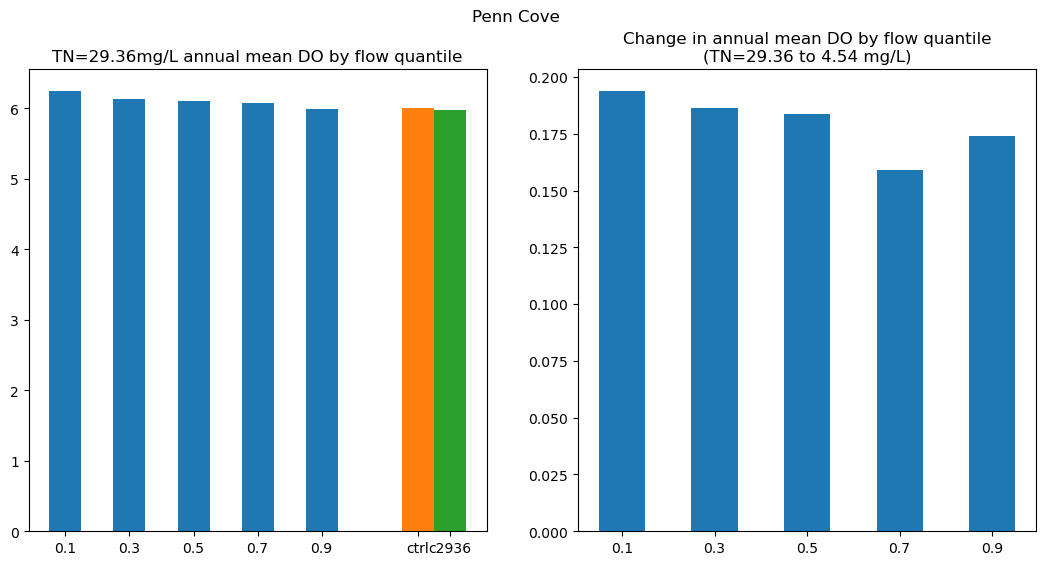

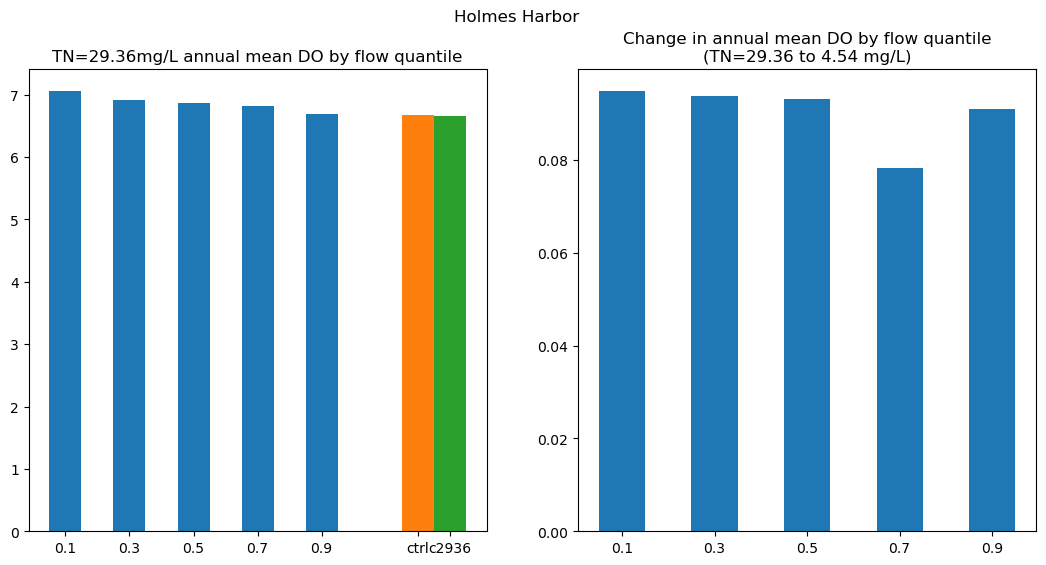

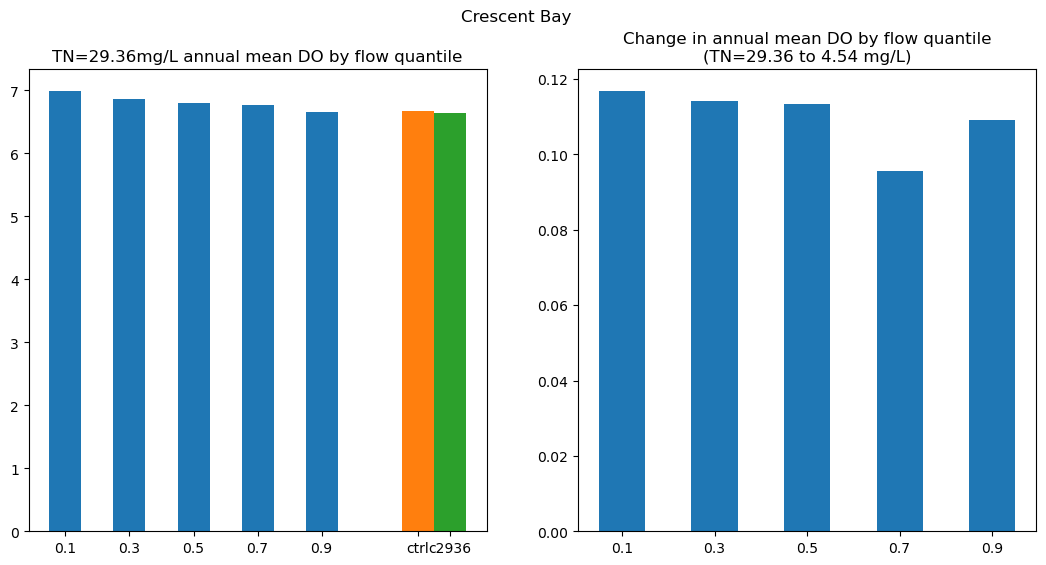

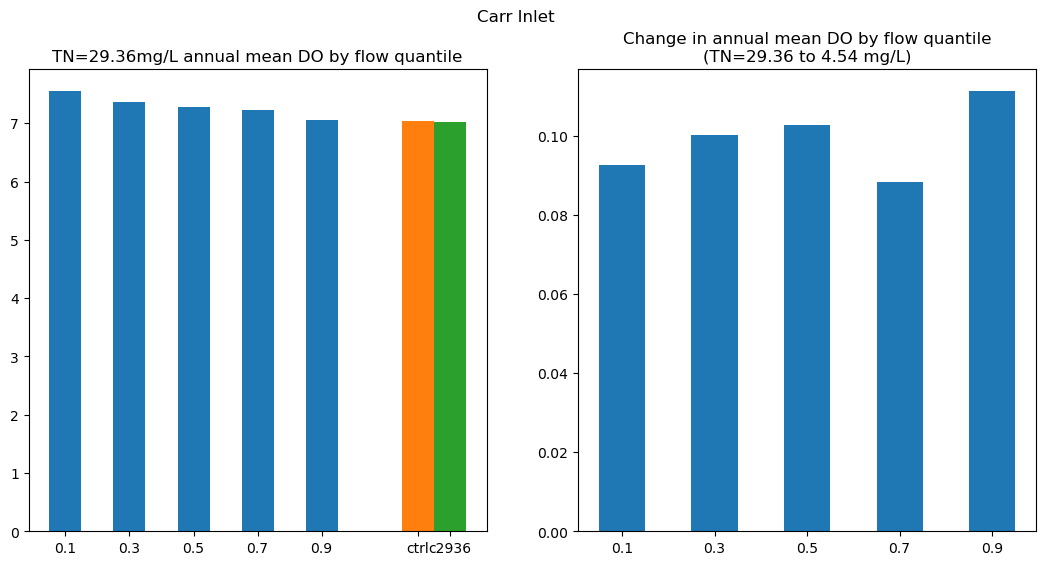

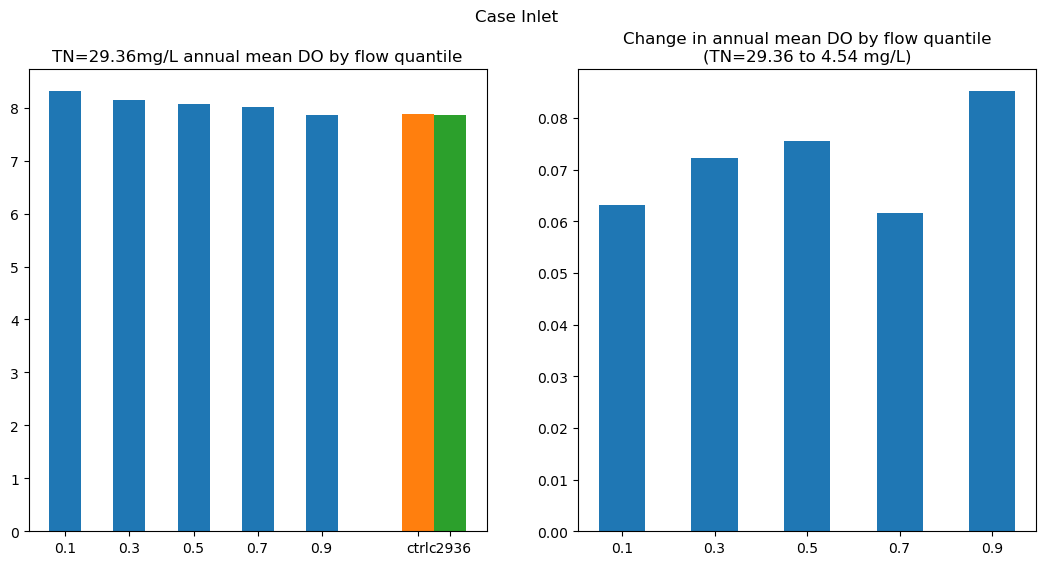

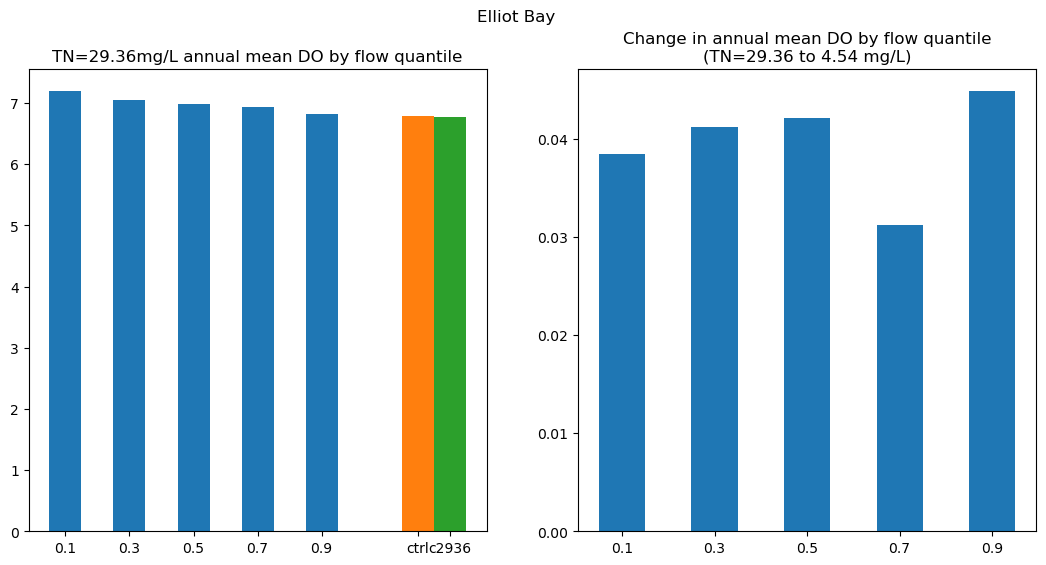

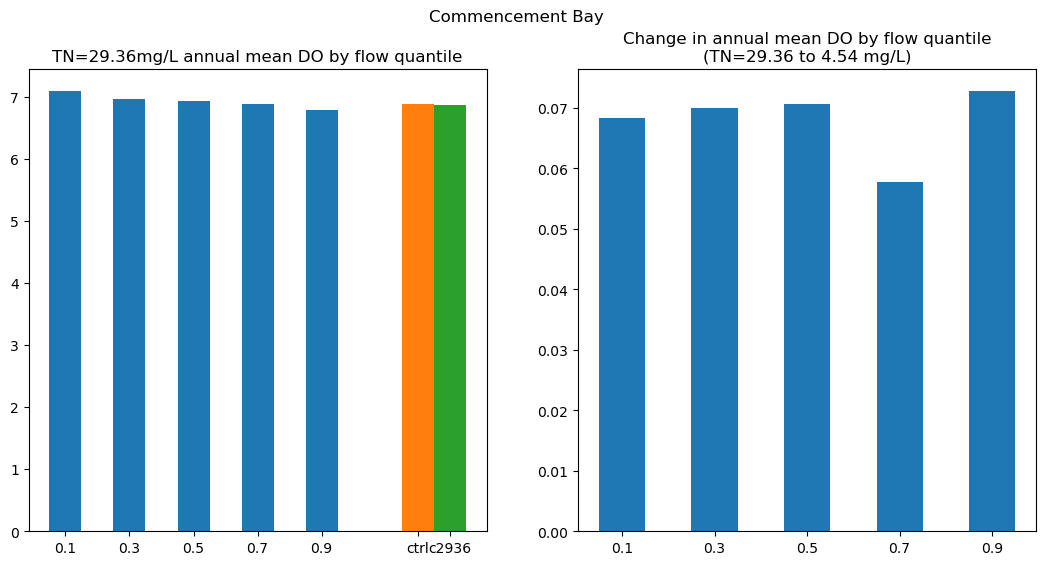

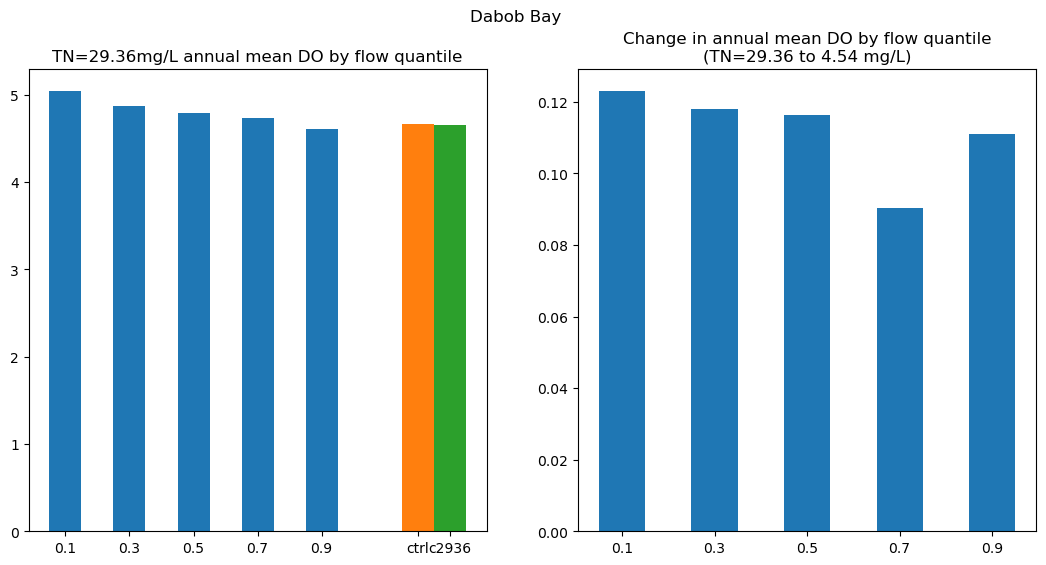

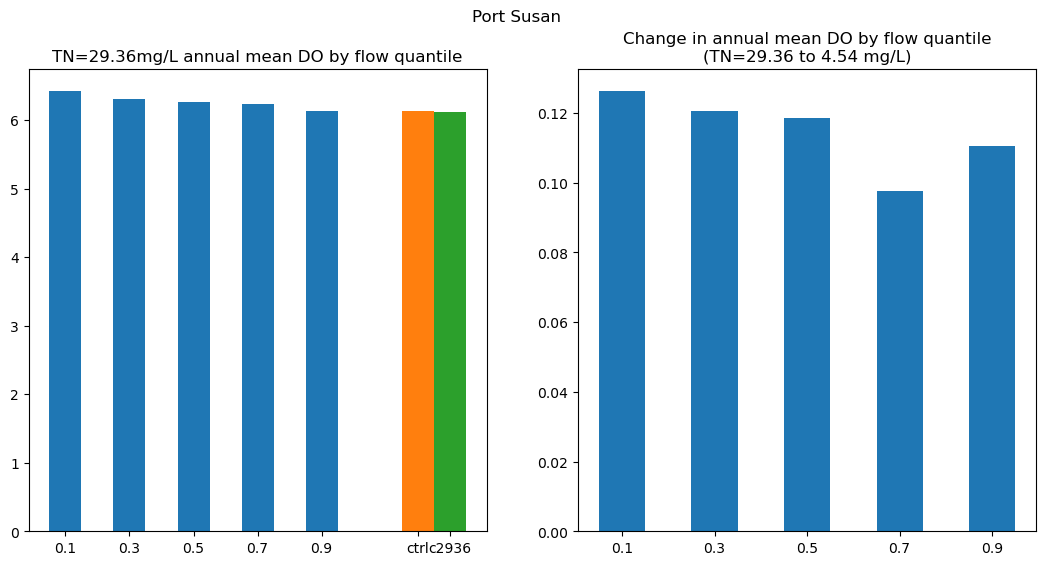

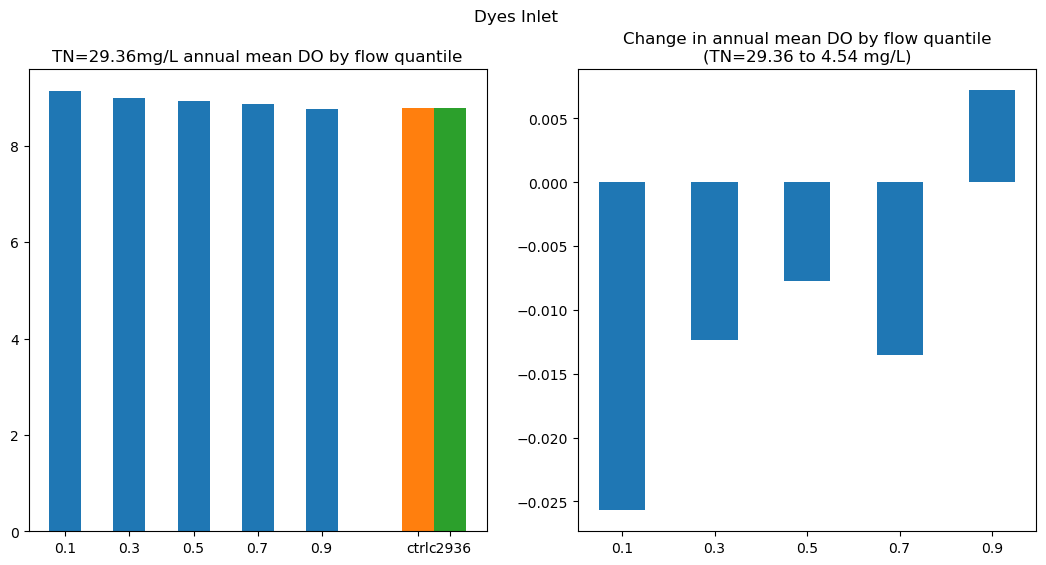

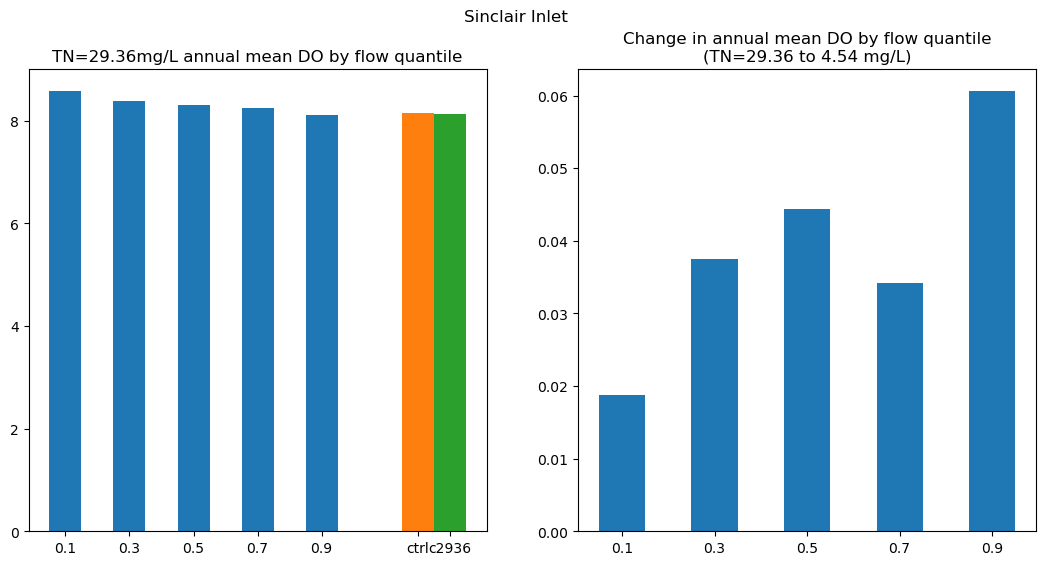

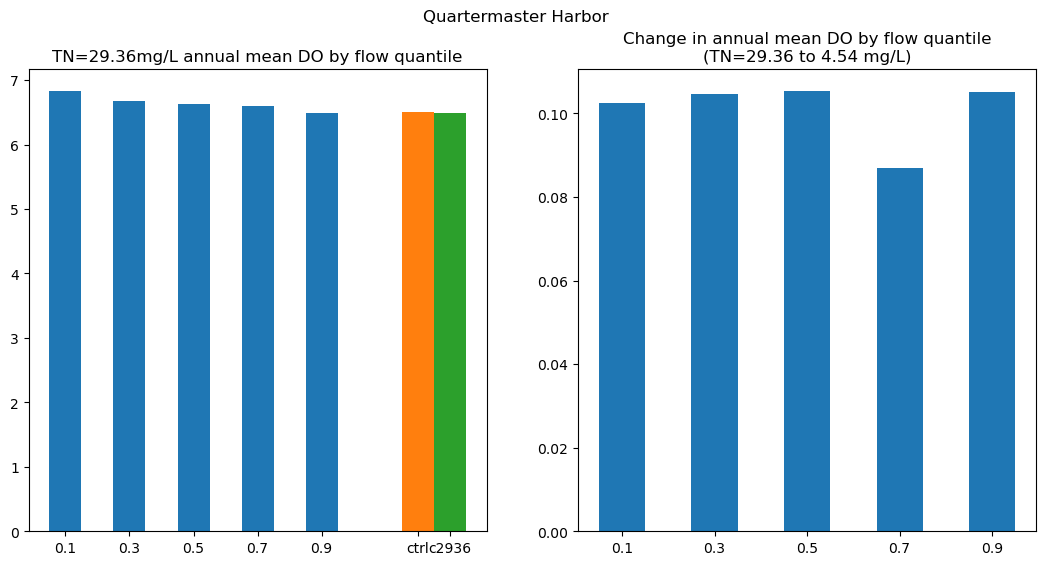

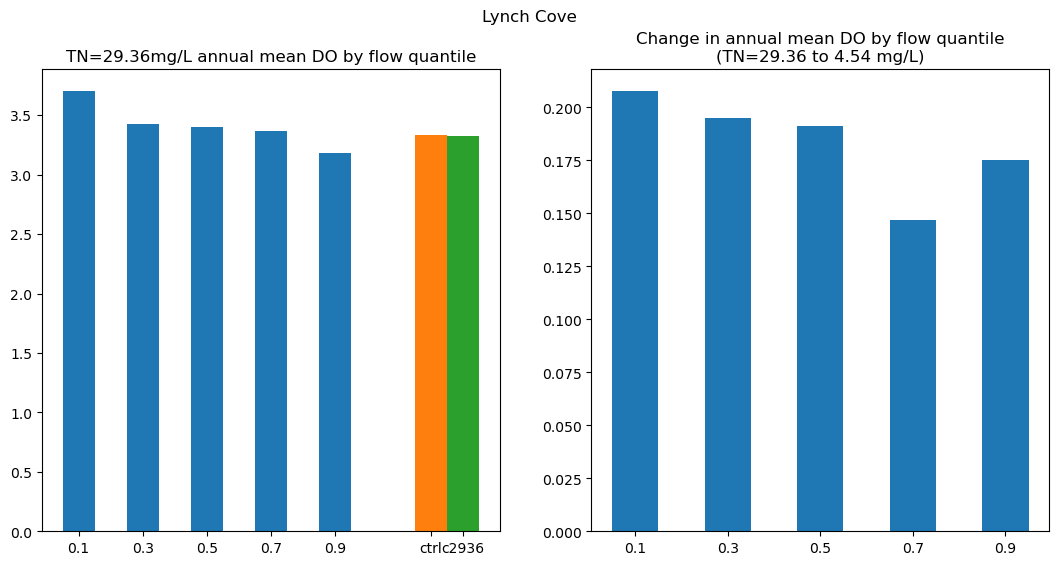

In [17]:
qs = np.array([1,3,5,7,9])
for cvname,cv in cvs.items():
    fig, axs = plt.subplots(1, 2, figsize=(13,6))
    df = mindo_avgs_by_cv[cvname]
    doavgs = [df[f'q{q}c2936'].mean() if f'q{q}c2936' in df.columns else np.nan for q in qs]
    axs[0].bar(qs/10, doavgs, width=0.1)
    axs[0].bar([1.2], [mindo_avgs_by_cv[cvname]['control'].mean()], width=0.1)
    axs[0].bar([1.3], [mindo_avgs_by_cv[cvname]['c2936'].mean()], width=0.1)
    axs[0].set_xticks((qs / 10).tolist() + [1.2,1.3], (qs / 10).tolist() + ['ctrl','c2936'])
    axs[0].set_title(f'TN=29.36mg/L annual mean DO by flow quantile')
    dodeltas = [df[f'q{q}c454'].mean() - df[f'q{q}c2936'].mean() if f'q{q}c2936' in df.columns and f'q{q}c454' in df.columns else np.nan for q in qs]
    axs[1].bar(qs/10, dodeltas, width=0.1)
    axs[1].set_title('Change in annual mean DO by flow quantile\n(TN=29.36 to 4.54 mg/L)')
    axs[1].set_xticks((qs / 10).tolist())
    fig.suptitle(cvname)

'No hypoxia for Holmes Harbor'

'No hypoxia for Crescent Bay'

'No hypoxia for Carr Inlet'

'No hypoxia for Case Inlet'

'No hypoxia for Elliot Bay'

'No hypoxia for Commencement Bay'

'No hypoxia for Dyes Inlet'

'No hypoxia for Quartermaster Harbor'

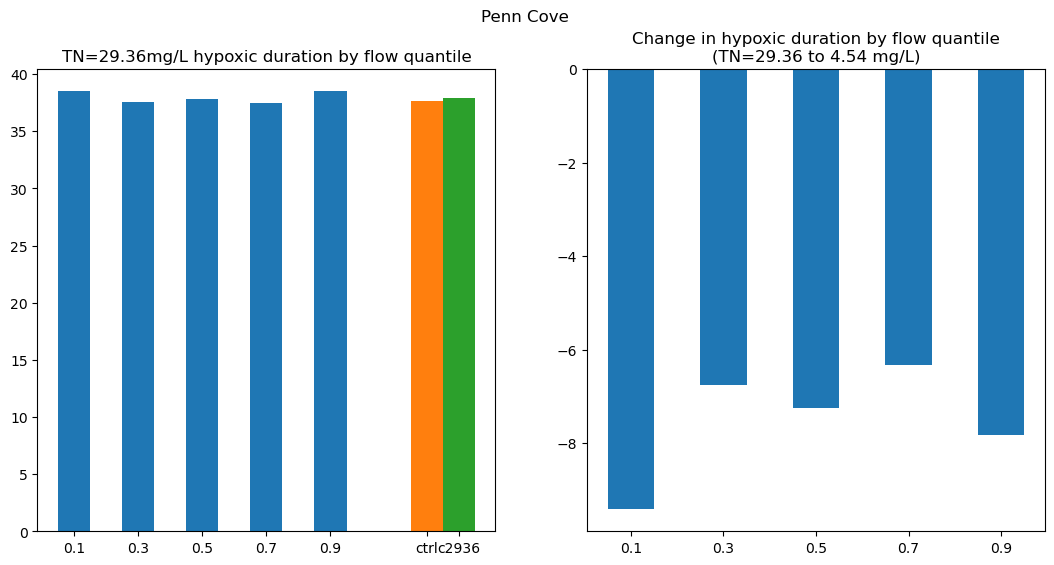

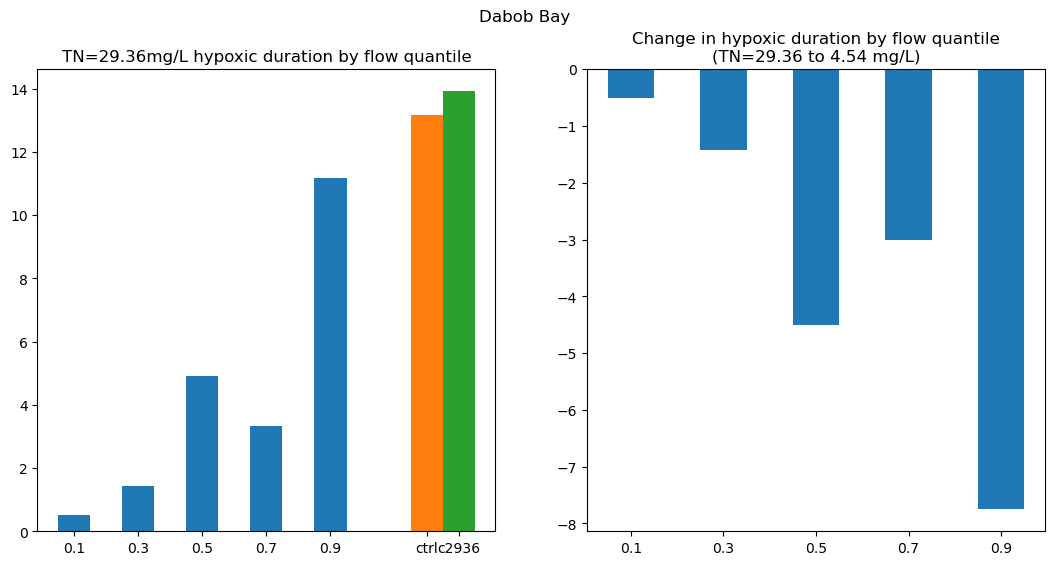

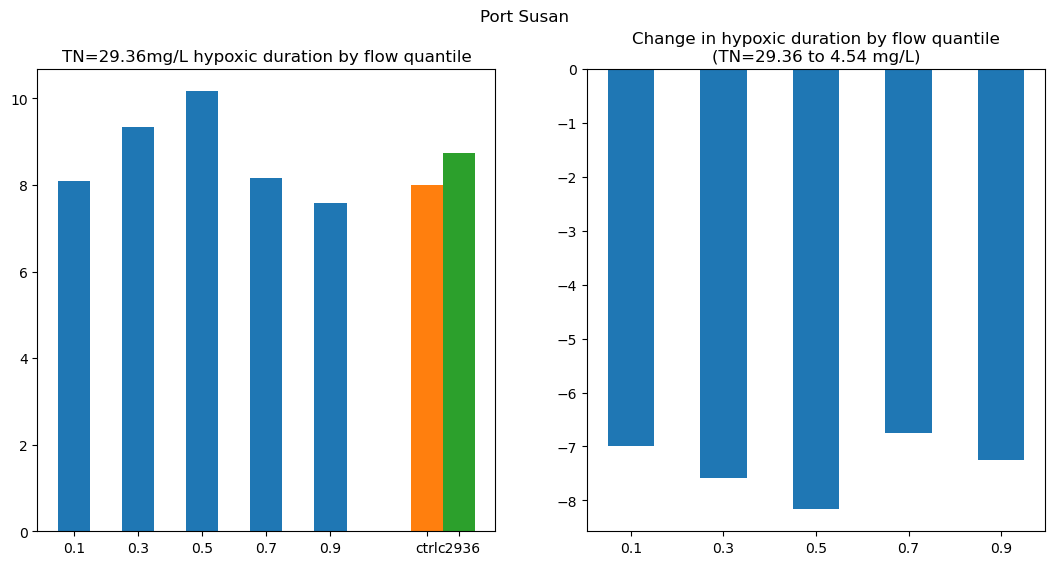

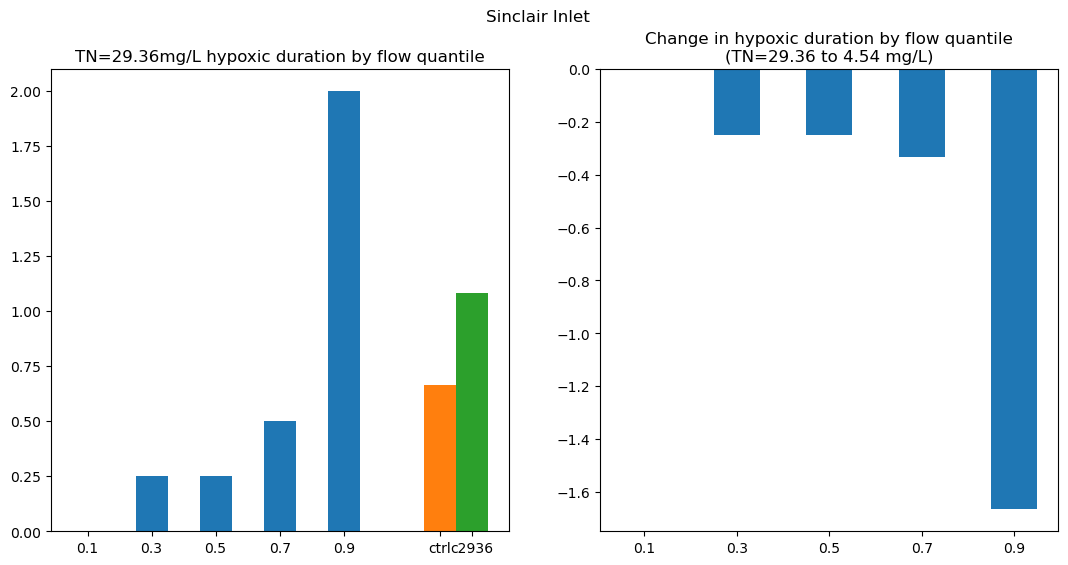

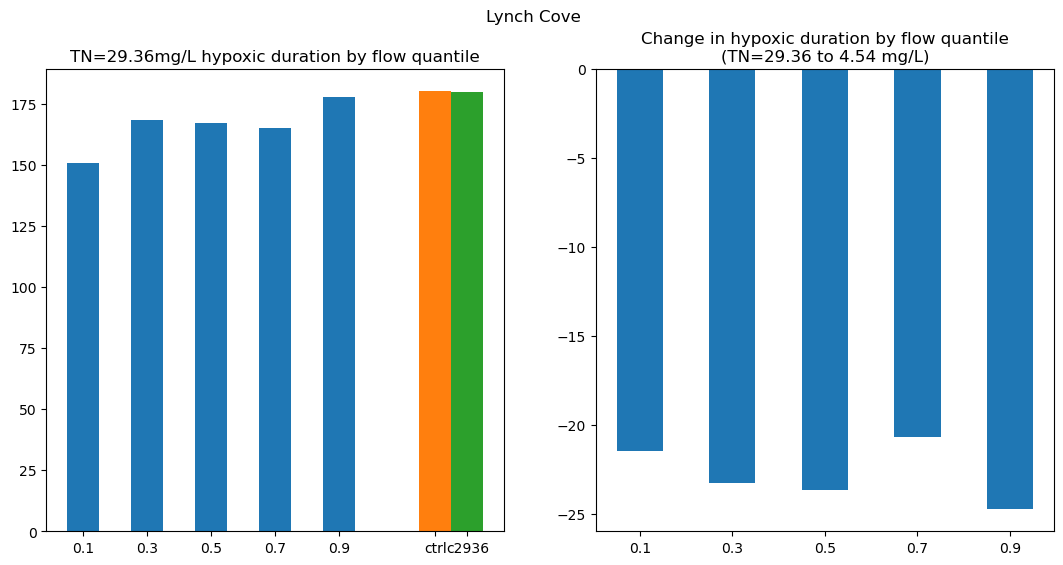

In [18]:
for cvname,cv in cvs.items():
    if durations_df[cvname].max() == 0:
        display(f'No hypoxia for {cvname}')
        continue
    fig, axs = plt.subplots(1, 2, figsize=(13,6))
    durations = [durations_df.loc[f'q{q}c2936', cvname] if f'q{q}c2936' in durations_df.index else np.nan for q in qs]
    axs[0].bar(qs/10, durations, width=0.1)
    axs[0].bar([1.2], [durations_df.loc['control', cvname]], width=0.1)
    axs[0].bar([1.3], [durations_df.loc['c2936', cvname]], width=0.1)
    axs[0].set_xticks((qs / 10).tolist() + [1.2,1.3], (qs / 10).tolist() + ['ctrl','c2936'])
    axs[0].set_title(f'TN=29.36mg/L hypoxic duration by flow quantile')
    deltas = [durations_df.loc[f'q{q}c454', cvname] - durations_df.loc[f'q{q}c2936', cvname] if f'q{q}c2936' in durations_df.index and f'q{q}c454' in durations_df.index else np.nan for q in qs]
    axs[1].bar(qs/10, deltas, width=0.1)
    axs[1].set_title('Change in hypoxic duration by flow quantile\n(TN=29.36 to 4.54 mg/L)')
    axs[1].set_xticks((qs / 10).tolist())
    fig.suptitle(cvname)

Get an estimate of mean DO below the pycnocline by looking at all areas below 20 meters.

In [19]:
crit_depth = 20

nodes = grid.nodes_gdf()
# This is a bit tricky: a node can have a depth just over crit_depth but the
# center of the bottom sigma layer, where scalars are computed, may be just under.
deep_nodes = nodes.loc[np.isin(nodes.index, data['node'][:]) & (nodes['depth'] * -data['siglay'][-1] > crit_depth)]
idxs = np.searchsorted(data['node'][:], deep_nodes.index.tolist())
idxs

array([   0,    1,    2, ..., 3091, 3097, 3098])

<Axes: >

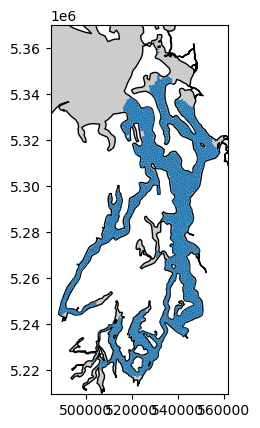

In [31]:
cv = ControlVolume(grid=grid, nodes=set(data['node'][idxs]))
cv.plot()

This is the process for each experiment.

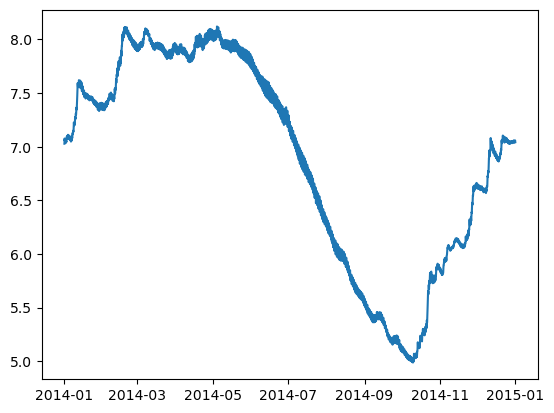

In [20]:
# Go through all indices and find the matching siglayer cutoff
doavg_deep = np.zeros((data.dimensions['time'].size, len(idxs)))
depths = deep_nodes['depth'].to_numpy()
for i,(n,d) in enumerate(zip(idxs,depths)):
    # Need to make sure depths are positive so the level list is sorted ascending
    crit_idx = np.searchsorted(data['siglay'][:] * -d, crit_depth)
    pull = data['controlDOXG'][:,crit_idx:,n]
    #display((n,d,crit_idx))
    #display(data['siglay'][:] * -d)
    #display(pull)
    doavg_deep[:,i] = pull.mean(axis=1)
fig, ax = plt.subplots()
ax.plot(dates, np.average(doavg_deep, axis=1, weights=areas.iloc[idxs]))

In [21]:
doavg_deep = {}
for v in sort(data.variables):
    name = v[:-4]
    print(name)
    r = np.zeros((data.dimensions['time'].size, len(idxs)))
    for i,(n,d) in enumerate(zip(idxs,depths)):
        # Need to make sure depths are positive so the level list is sorted ascending
        crit_idx = np.searchsorted(data['siglay'][:] * -d, crit_depth)
        pull = data[v][:,crit_idx:,n]
        r[:,i] = pull.mean(axis=1)
    doavg_deep[name] = np.average(r, axis=1, weights=areas.iloc[idxs])
doavg_deep_df = pd.DataFrame(doavg_deep, index=dates)
doavg_deep_df.head()

control
c2936
q1c454
q1c10
q1c15
q1c20
q1c25
q1c2936
q3c454
q3c10
q3c15
q3c20
q3c25
q3c2936
q5c454
q5c10
q5c15
q5c20
q5c25
q5c2936
q7c454
q7c10
q7c15
q7c20
q7c25
q7c2936
q9c454
q9c10
q9c15
q9c20
q9c25
q9c2936


,control,c2936,q1c454,q1c10,q1c15,q1c20,q1c25,q1c2936,q3c454,q3c10,...,q7c15,q7c20,q7c25,q7c2936,q9c454,q9c10,q9c15,q9c20,q9c25,q9c2936
2014-01-01 01:59:20.000109670,7.027708,7.009184,7.655506,7.638981,7.623751,7.608624,7.593468,7.580313,7.482078,7.465426,...,7.311320,7.295843,7.280315,7.276645,7.221334,7.204838,7.189511,7.174062,7.158543,7.145043
2014-01-01 03:59:20.000324250,7.039633,7.022122,7.667151,7.650554,7.635263,7.620076,7.604861,7.591653,7.494400,7.477683,...,7.323940,7.308409,7.292819,7.289129,7.234268,7.217711,7.202326,7.186824,7.171255,7.157712
2014-01-01 05:59:19.999895098,7.076177,7.056435,7.702220,7.685693,7.670463,7.655321,7.640153,7.626982,7.529190,7.512533,...,7.358256,7.342797,7.327286,7.323737,7.267333,7.250873,7.235578,7.220165,7.204691,7.191230
2014-01-01 07:59:19.999465938,7.055879,7.034787,7.677941,7.661574,7.646498,7.631508,7.616477,7.603433,7.504991,7.488499,...,7.334545,7.319240,7.303884,7.300453,7.243247,7.226936,7.211780,7.196508,7.181179,7.167840
2014-01-01 09:59:20.000324250,7.062786,7.039667,7.682290,7.666045,7.651078,7.636200,7.621254,7.608276,7.509515,7.493154,...,7.338740,7.323553,7.308304,7.304993,7.246632,7.230433,7.215382,7.200217,7.184995,7.171755


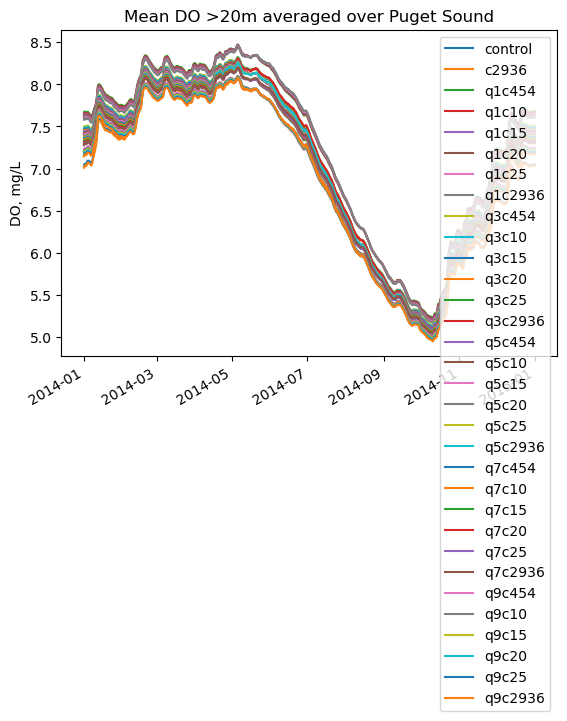

In [22]:
fig, ax = plt.subplots()
for name in doavg_deep_df.columns:
    doavg_deep_df[name].rolling('1D').mean().plot(ax=ax, label=name)
ax.set(title=f'Mean DO >{crit_depth}m averaged over Puget Sound', ylabel='DO, mg/L')
ax.legend()

In [23]:
doavg_deep_df.to_excel(f'results/puget_sound/doavg_below{crit_depth}m.xlsx')

Repeat for bottom-layer DO of all deep nodes

In [27]:
dobot_deep = {}
for v in sort(data.variables):
    name = v[:-4]
    print(name)
    r = data[v][:,-1,idxs]
    dobot_deep[name] = np.average(r, axis=1, weights=areas.iloc[idxs])
dobot_deep_df = pd.DataFrame(dobot_deep, index=dates)
dobot_deep_df.head()

control
c2936
q1c454
q1c10
q1c15
q1c20
q1c25
q1c2936
q3c454
q3c10
q3c15
q3c20
q3c25
q3c2936
q5c454
q5c10
q5c15
q5c20
q5c25
q5c2936
q7c454
q7c10
q7c15
q7c20
q7c25
q7c2936
q9c454
q9c10
q9c15
q9c20
q9c25
q9c2936


,control,c2936,q1c454,q1c10,q1c15,q1c20,q1c25,q1c2936,q3c454,q3c10,...,q7c15,q7c20,q7c25,q7c2936,q9c454,q9c10,q9c15,q9c20,q9c25,q9c2936
2014-01-01 01:59:20.000109670,6.720109,6.696637,7.404995,7.386402,7.369282,7.352313,7.335332,7.320601,7.211387,7.192779,...,7.023352,7.006180,6.988973,6.985486,6.929691,6.911483,6.894586,6.877578,6.860521,6.845700
2014-01-01 03:59:20.000324250,6.735352,6.712917,7.416539,7.397811,7.380570,7.363483,7.346385,7.331554,7.224757,7.206013,...,7.038050,7.020762,7.003435,6.999908,6.945575,6.927247,6.910236,6.893116,6.875954,6.861041
2014-01-01 05:59:19.999895098,6.776626,6.753071,7.455404,7.436674,7.419430,7.402320,7.385200,7.370349,7.264341,7.245581,...,7.077495,7.060229,7.042928,7.039536,6.984198,6.965910,6.948943,6.931871,6.914764,6.899896
2014-01-01 07:59:19.999465938,6.756258,6.734786,7.432442,7.413839,7.396722,7.379742,7.362731,7.347986,7.242168,7.223583,...,7.056068,7.038935,7.021768,7.018481,6.962933,6.944748,6.927875,6.910901,6.893900,6.879119
2014-01-01 09:59:20.000324250,6.761213,6.740054,7.436501,7.418033,7.401044,7.384200,7.367287,7.352614,7.246612,7.228174,...,7.060440,7.043430,7.026363,7.023225,6.966413,6.948316,6.931527,6.914638,6.897723,6.883026


In [28]:
dobot_deep_df.to_excel(f'results/puget_sound/dobot_below{crit_depth}m.xlsx')

In [24]:
data.close()